In [1]:
import itertools
import random
import matplotlib.pyplot as plt

%matplotlib inline
import networkx as nx

#  Network models

Contents:
1. [Random network model](#1.-Random-Network-Model)
2. [Small-World model](#2.-Small-World-Model)
3. [Preferential attachment model](#3.-Preferential-Attachment-Model)


## 1. Random Network Model

The random network model has two parameters: the number of nodes $N$, and the link probability $p$. The algorithm for creating this network is as follows:

1. Select a pair of nodes, say i and j.
2. Generate a random number r between 0 and 1. If r < p, then add a link between i and j.
3. Repeat (1) and (2) for all pairs of nodes.


### Gilbert random graph model

In [2]:
def gnp_random_graph(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))

    for i, j in itertools.combinations(G.nodes(), 2):
        r = random.random()
        if r < p:
            G.add_edge(i, j)
        # Do nothing if r >= p

    return G

We can use this function to generate a graph. Since this is a random graph, each execution of the following code will generate a different graph.

Graph has 484 edges.


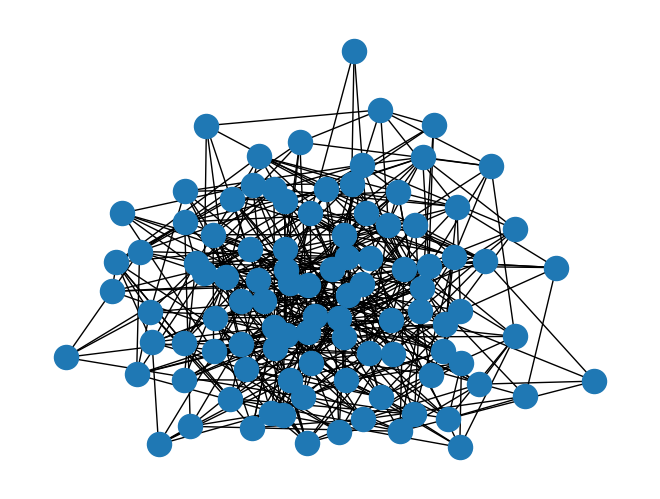

In [3]:
G = gnp_random_graph(100, 0.1)
nx.draw(G)
print('Graph has', G.number_of_edges(), 'edges.')

Run the above cell a few times and note that the number of edges varies slightly among random graphs generated with the same parameters. This is because each pair of nodes has an independent chance of being an edge.

### Erdös-Rényi random graph model

Instead of specifying the link probability $p$, we can also generate a graph of $N$ nodes with exactly $M$ edges by using `random.sample()` to choose M of the possible edges generated with `itertools.combinations()`:

In [4]:
def gnm_random_graph(N, M):
    G = nx.Graph()
    G.add_nodes_from(range(N))

    possible_edges = itertools.combinations(G.nodes(), 2)
    edges_to_add = random.sample(list(possible_edges), M)
    G.add_edges_from(edges_to_add)

    return G

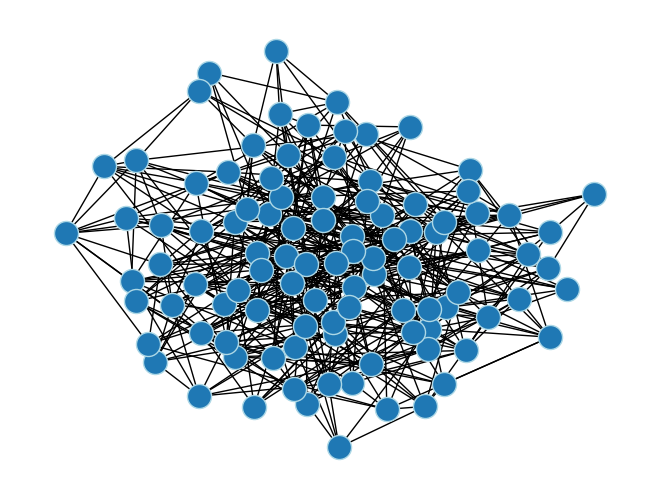

In [5]:
G = gnm_random_graph(100, 500)
pos = nx.spring_layout(G)
nx.draw(G,edgecolors='lightblue')
plt.savefig('graph_er.jpg')

### NetworkX functions

NetworkX has a function for the $G_{n,p}$ random graph specifying number of nodes $N$ and link probability $p$:  [gnp_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html).

In addition, NetworkX provides [gnm_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html), which generates a $G_{n,m}$ graph, where we specify the number of nodes $N$ and the desired number of edges $M$.

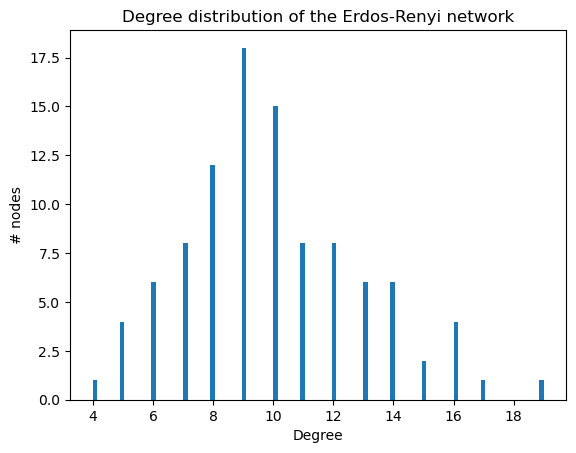

In [6]:
degrees = dict(G.degree()).values() # degree returns a view object DegreeView
degree_hist = plt.hist(list(degrees), 100)
plt.xlabel('Degree')
plt.ylabel('# nodes')
plt.title('Degree distribution of the Erdos-Renyi network')
#plt.show()
plt.savefig('histo_er.jpg')
plt.show()

## 3. Small-World Model

The algorithm for generating a small-world network is as such:

1. Begin with a ring of $N$ nodes
2. Connect each node to its $k$ nearest neighbors (or $k-1$ if k is odd).
3. For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with $(u, w)$ where $w$ is not a neighbor of $u$.

We'll do these step-by-step first, and combine them into a function last.

### Create a ring of N nodes

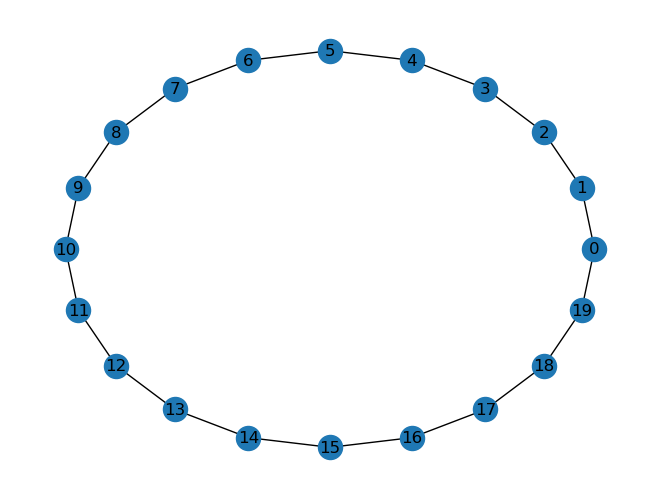

In [7]:
N = 20
G = nx.cycle_graph(N)
nx.draw_circular(G, with_labels=True)

### Connect each node to its $k$ nearest neighbors

We'll use modular arithmetic in order to do this. As an example of why, let's say $k$ is 4. So for node $n$, we want to add edges to $n$'s 4 nearest neighbors: $n-1, n+1, n-2,$ and $n+2.$ Since our nodes are in a circle, these can "wrap around", *e.g.* the 4 nearest neighbors of node 0 are N-1, 1, N-2, and 2.

Note the use of integer division (//) below. Integer division throws away the fractional part of division, e.g.

    5 // 2 = 2

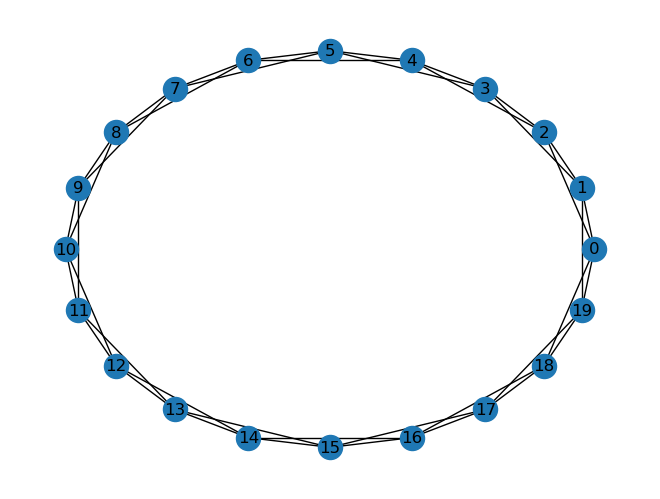

In [8]:
k = 4

for n in G.nodes():
    for i in range(1, k // 2 + 1):
        left  = (n-i) % N
        right = (n+i) % N
        G.add_edge(n, left)
        G.add_edge(n, right)

nx.draw_circular(G, with_labels=True)

### Rewire some edges

> For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with (u, w) where $w$ is not a neighbor of $u$.

For this step, we make use of set arithmetic in order to generate a list of nodes that are not neighbors of $u$, and `random.choice` to select $w$ at random from that set of "not neighbors."

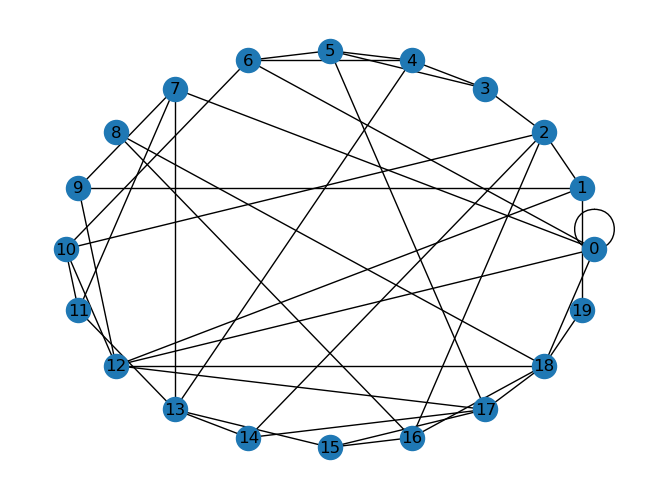

In [9]:
p = 0.6

for u, v in list(G.edges()):
    if random.random() < p:
        not_neighbors = set(G.nodes()) - set(G.neighbors(u))
        w = random.choice(list(not_neighbors))
        G.remove_edge(u, v)
        G.add_edge(u, w)

nx.draw_circular(G, with_labels=True)

### Watts-Strogatz Small-World Model

We can put this together to write a basic function for the small-world model:

In [10]:
def watts_strogatz_graph(N, k, p):
    # 1. Create a ring of N nodes
    G = nx.cycle_graph(N)

    # 2. Connect each node n to k nearest neighbors
    #    [n-(k//2), ... , n-1, n+1, ... , n+(k//2)]
    for n in G.nodes():
        for i in range(1, k // 2 + 1):
            left  = (n-i) % N
            right = (n+i) % N
            G.add_edge(n, left)
            G.add_edge(n, right)

    # 3. Rewire edges with probability p
    for u, v in list(G.edges()):
        if random.random() < p:
            not_neighbors = set(G.nodes()) - set(G.neighbors(u)) - {u}
            w = random.choice(list(not_neighbors))
            G.remove_edge(u, v)
            G.add_edge(u, w)

    return G

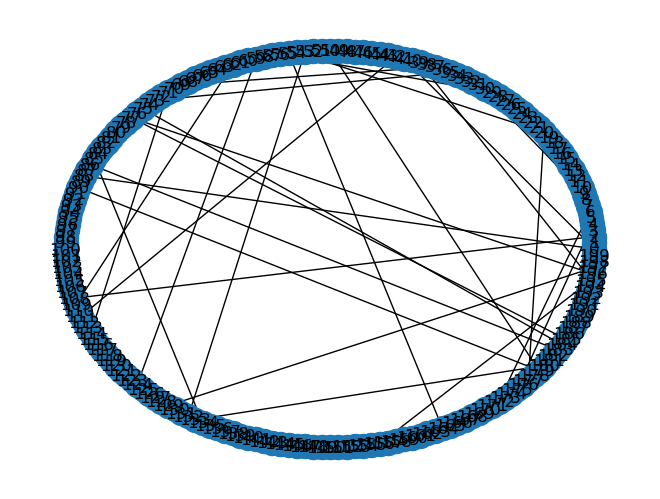

In [11]:
G = watts_strogatz_graph(200, 4, 0.1)
nx.draw_circular(G, with_labels=True)

In [12]:
# Average distance
nx.average_shortest_path_length(G)

6.49391959798995

### NetworkX function

NetworkX has a function for this model: [watts_strogatz_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html).

## 4. Preferential Attachment Model

The Barabási-Albert preferential attachment model has two parameters: the number of nodes $N$, and the number of links added at each step $m$. Given these parameters, the algorithm is as follows:

1. Start with a clique of $m + 1$ nodes.
2. Select $m$ different nodes at random, weighted by their degree.
3. Add a new node $i$ and link it with the $m$ nodes from the previous step.
4. Repeat 2-3 until there are N nodes in the graph.

The code for this is thus straightforward, with one possible exception: for step 3, we need to generate a *degree sequence* to weight the random selection. If we have a graph `G`, we can generate such a degree sequence with a list comprehension as follows:

[4, 1, 1, 1, 1]


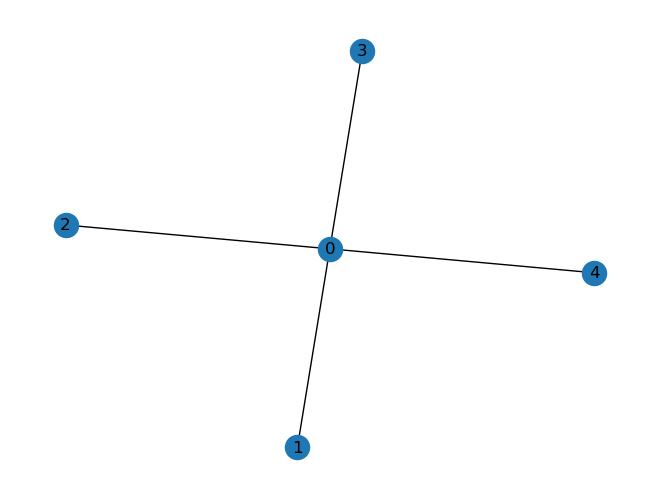

In [13]:
G = nx.star_graph(4)
degrees = [G.degree(n) for n in G.nodes()]

print(degrees)
nx.draw(G, with_labels=True)

Note that the degree sequence is output in the same order as the nodes, such that the node at index $i$ in that list has the degree at index $i$ of the corresponding degree sequence. With this, we can write a function for the BA preferential attachment model:

In [14]:
def barabasi_albert_graph(N, m):
    # 1. Start with a clique of m+1 nodes
    G = nx.complete_graph(m + 1)
    for i in range(G.number_of_nodes(), N):
        # 2. Select m different nodes at random, weighted by their degree.
        new_neighbors = []
        possible_neighbors = list(G.nodes())
        for _ in range(m):
            degrees = [G.degree(n) for n in possible_neighbors]

            j = random.choices(possible_neighbors, degrees)[0]
            new_neighbors.append(j)
            possible_neighbors.remove(j)

        # 3. Add a new node i and link it with the m nodes from the previous step.
        for j in new_neighbors:
            G.add_edge(i, j)

    return G

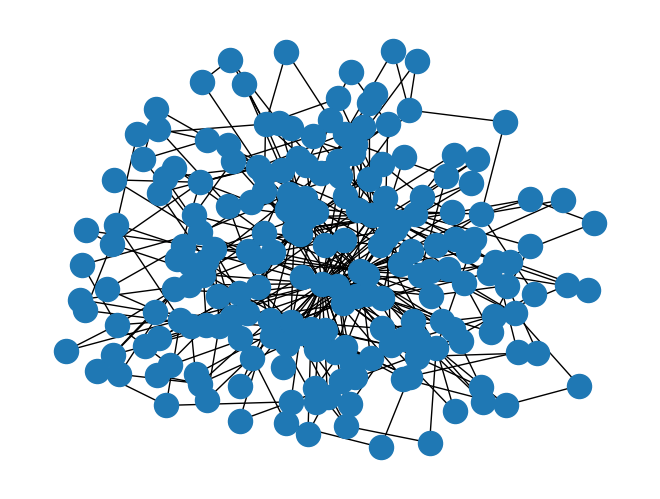

In [15]:
G = barabasi_albert_graph(200, 2)
nx.draw(G)
plt.savefig('graph_ba.jpg')

One might wonder why, in the previous code for `preferential_attachment_graph`, we didn't just write step 2 as

    new_neighbors = random.choices(G.nodes, degrees, k=m)
    
The issue here is that when one specifies $k > 1$ for `random.choices`, the selection is made with replacement, *i.e.* the same node can be selected from the list multiple times. The more complicated code is necessary so that we choose $m$ different nodes to join with node $i$.

### NetworkX function

As with all of these graph models, NetworkX has a function to generate a BA model: [barabasi_albert_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html).

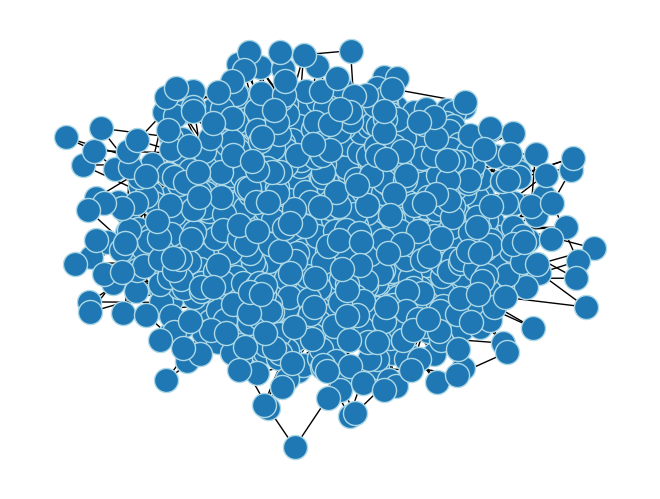

In [16]:
G_BA = nx.barabasi_albert_graph(1000, 2)
nx.draw(G_BA,edgecolors='lightblue')
plt.savefig('graph_ba.jpg')

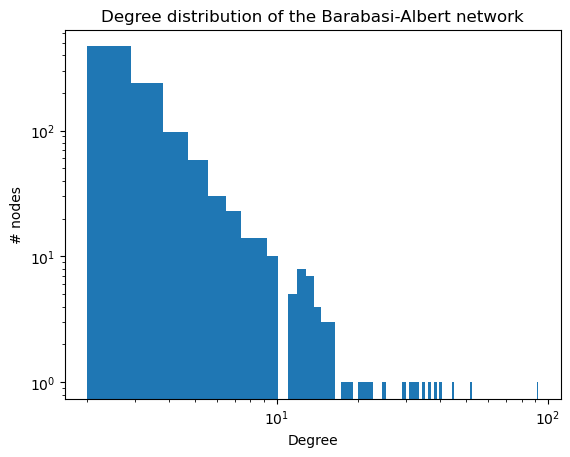

In [17]:
degrees = dict(G_BA.degree()).values() # degree returns a view object DegreeView
degree_hist = plt.hist(list(degrees), 100)
plt.xlabel('Degree')
plt.ylabel('# nodes')
plt.title('Degree distribution of the Barabasi-Albert network')
#plt.show()
plt.xscale('log')
plt.yscale('log')
plt.savefig('histo_ba.jpg')
plt.show()

## Exploration

#### Iris Vukovic

Random networks are used to simulate and understand properties of real-world networks, such as social or biological networks, and plan for unpredictable situations, such as disease outbreaks. For our previous assignment, I worked with a social network among students in Copenhagen. I am wondering if it is comparable or imitateable by one of the random network models described above.

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import networkx as nx
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression

From the multilayer Copenhagen students network, I'm choosing to focus my attention on the Facebook interactions network, which illustrates the friendship network among the participants of the study. First I'm loading the data, cleaning it, and visualizing.

In [23]:
DATA_DIR = "./"
DATA_FILENAMES = {"facebook_friends": "fb_friends.csv"}

In [24]:
def LoadData(data_filename, data_dir):
  '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
  return pd.read_csv(os.path.join(data_dir, data_filename)) 

In [25]:
df_facebook_friends = LoadData(DATA_FILENAMES["facebook_friends"], DATA_DIR)
print("\nfacebook friends\n", df_facebook_friends.head())


facebook friends
    # user_a  user_b
0         0     512
1         0     263
2         0     525
3         0     285
4         0     543


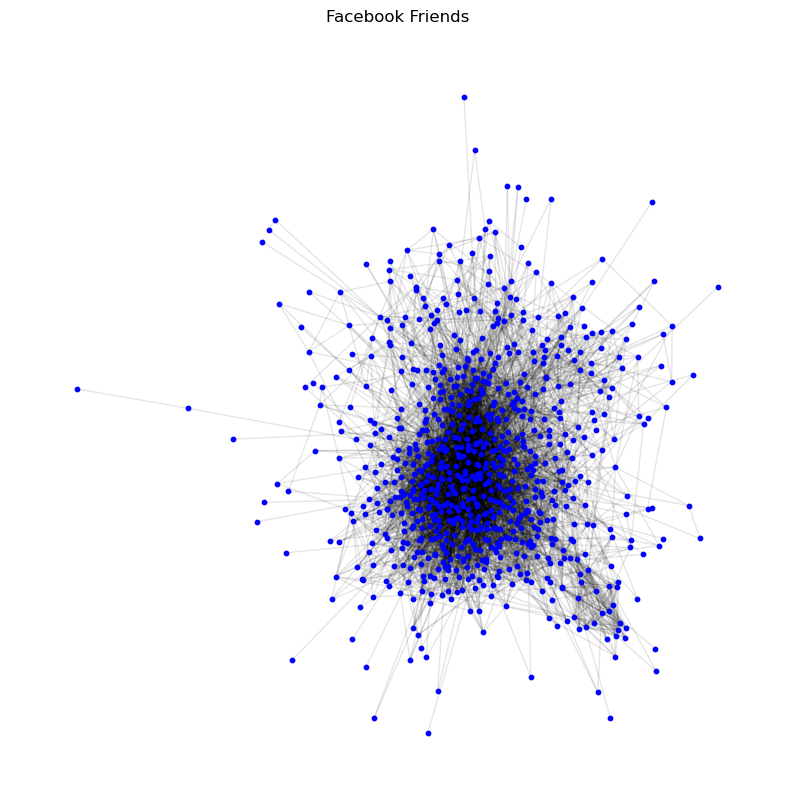

In [26]:
#visualize the data using networkx
G = nx.from_pandas_edgelist(df_facebook_friends, source='# user_a', target='user_b')
self_loops = list(nx.selfloop_edges(G))
G.remove_edges_from(nx.selfloop_edges(G))  # Remove self-loops
plt.figure(figsize=(10, 10))
plt.title("Facebook Friends")
plt.axis('off')
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue')
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.show()


In [ ]:
#compute degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
print("Degree sequence: ", degree_sequence)

#compute clustering coefficient
clustering_coeff = nx.clustering(G)
print("Clustering coefficient: ", clustering_coeff)

#compute average path length
avg_path_length = nx.average_shortest_path_length(G)
print("Average path length: ", avg_path_length)

#compute diameter
diameter = nx.diameter(G)
print("Diameter: ", diameter)

#compute assortativity
assortativity = nx.degree_assortativity_coefficient(G)
print("Assortativity: ", assortativity)

Now, I am extracting nodes, edges, and the average degree in order to use later when attempting to reconstruct the network with different random models.

In [27]:
#extract number of nodes and edges
N = G.number_of_nodes()
M = G.number_of_edges()
print("Number of nodes: ", N)
print("Number of edges: ", M)

avg_deg = sum(dict(G.degree()).values()) / N
print("Average degree: ", avg_deg)

Number of nodes:  800
Number of edges:  6418
Average degree:  16.045


Finally, I create an Erdős–Rényi model, a Watts–Strogatz model, and a Barabási–Albert model using Networkx functions and compare statistics with the original network.

In [38]:
# Erdős–Rényi model
p_er = 2 * M / (N * (N - 1))
G_er = nx.erdos_renyi_graph(N, p_er)

# Watts–Strogatz model
k_ws = int(round(avg_deg))
if k_ws % 2 != 0:
    k_ws += 1  # make it even
G_ws = nx.watts_strogatz_graph(N, k_ws, 0.1)

# Barabási–Albert model
m_ba = int(avg_deg / 2)
G_ba = nx.barabasi_albert_graph(N, m_ba)

#function to calculate stats
def get_stats(G, name):
    return {
        "model": name,
        "avg_clustering": nx.average_clustering(G),
        "avg_path_length": nx.average_shortest_path_length(G) if nx.is_connected(G) else None,
        "degree_mean": sum(dict(G.degree()).values()) / G.number_of_nodes()
    }

#compare stats
stats_real = get_stats(G, "Real Network")
stats_er = get_stats(G_er, "Erdős–Rényi")
stats_ws = get_stats(G_ws, "Watts–Strogatz")
stats_ba = get_stats(G_ba, "Barabási–Albert")


#collect into a DataFrame
df_stats = pd.DataFrame([stats_real, stats_er, stats_ws, stats_ba])
df_stats = df_stats.rename(columns={
    "avg_clustering": "Avg. Clustering",
    "avg_path_length": "Avg. Path Length",
    "degree_mean": "Avg. Degree"
})

print(df_stats.to_string(index=False))

          model  Avg. Clustering  Avg. Path Length  Avg. Degree
   Real Network         0.315351          2.980025       16.045
    Erdős–Rényi         0.021254          2.702516       16.140
 Watts–Strogatz         0.511129          3.378839       16.000
Barabási–Albert         0.061421          2.618232       15.840


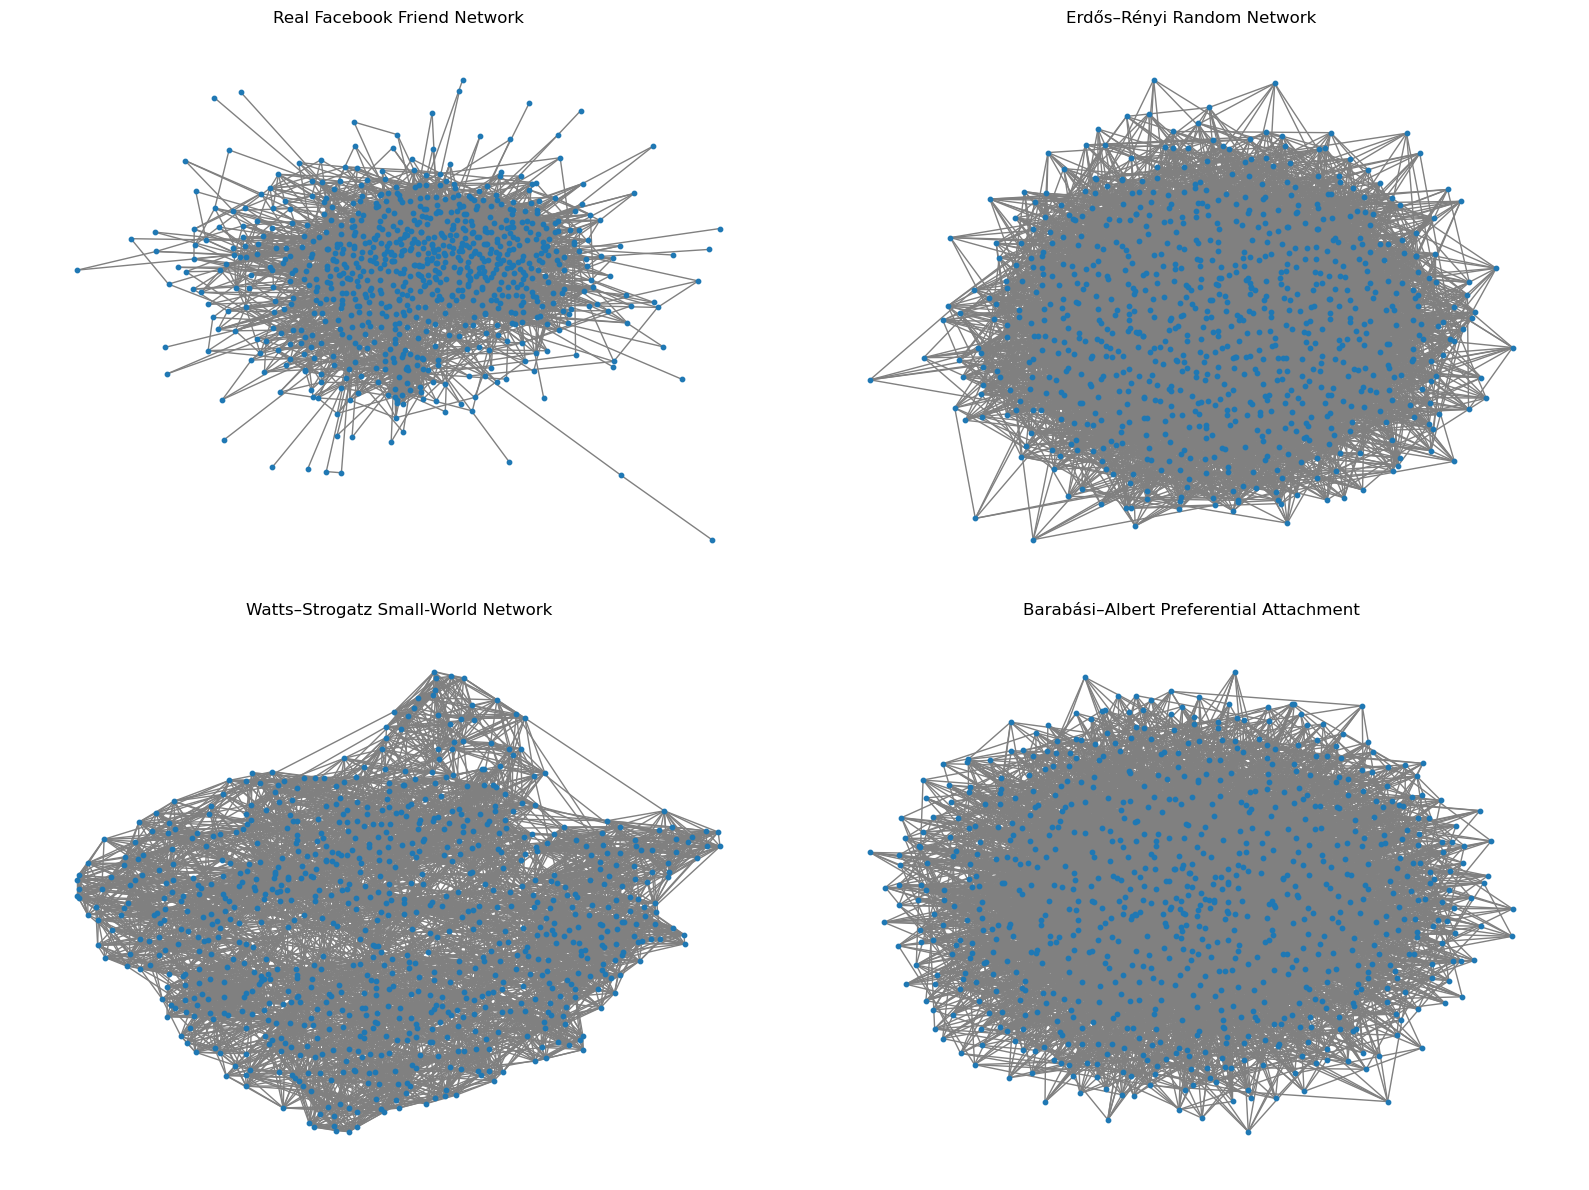

In [30]:
layout_real = nx.spring_layout(G, seed=42)
layout_er = nx.spring_layout(G_er, seed=42)
layout_ws = nx.spring_layout(G_ws, seed=42)
layout_ba = nx.spring_layout(G_ba, seed=42)

#plot all four networks
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

#real Network
axs[0, 0].set_title("Real Facebook Friend Network")
nx.draw(G, pos=layout_real, ax=axs[0, 0], node_size=10, edge_color='gray', with_labels=False)

# Erdős–Rényi
axs[0, 1].set_title("Erdős–Rényi Random Network")
nx.draw(G_er, pos=layout_er, ax=axs[0, 1], node_size=10, edge_color='gray', with_labels=False)

# Watts–Strogatz
axs[1, 0].set_title("Watts–Strogatz Small-World Network")
nx.draw(G_ws, pos=layout_ws, ax=axs[1, 0], node_size=10, edge_color='gray', with_labels=False)

# Barabási–Albert
axs[1, 1].set_title("Barabási–Albert Preferential Attachment")
nx.draw(G_ba, pos=layout_ba, ax=axs[1, 1], node_size=10, edge_color='gray', with_labels=False)

plt.tight_layout()
plt.show()


Analysing the table with statistics comparing the real network to the random networks designed to mimic it, the Watts–Strogatz model is the most similar to the FB friends network. It has even higher clustering than the FB friends network, which makes sense for a small-world model, and the average path length and average degree are also pretty close. The Erdős–Rényi model and Barabási–Albert model have comparable average path lengths and average degrees, but their clustering coefficients are quite small, which aligns with the fact that these types of random models don't capture tight community structures. This is due to E-R being purely random and B-A being a scale-free network in which higher-degree nodes don't have to form clusters. Thus, fromt this exploration, it seems as though the FB friends network displays small-world behavior, which makes sense since it is a social network.

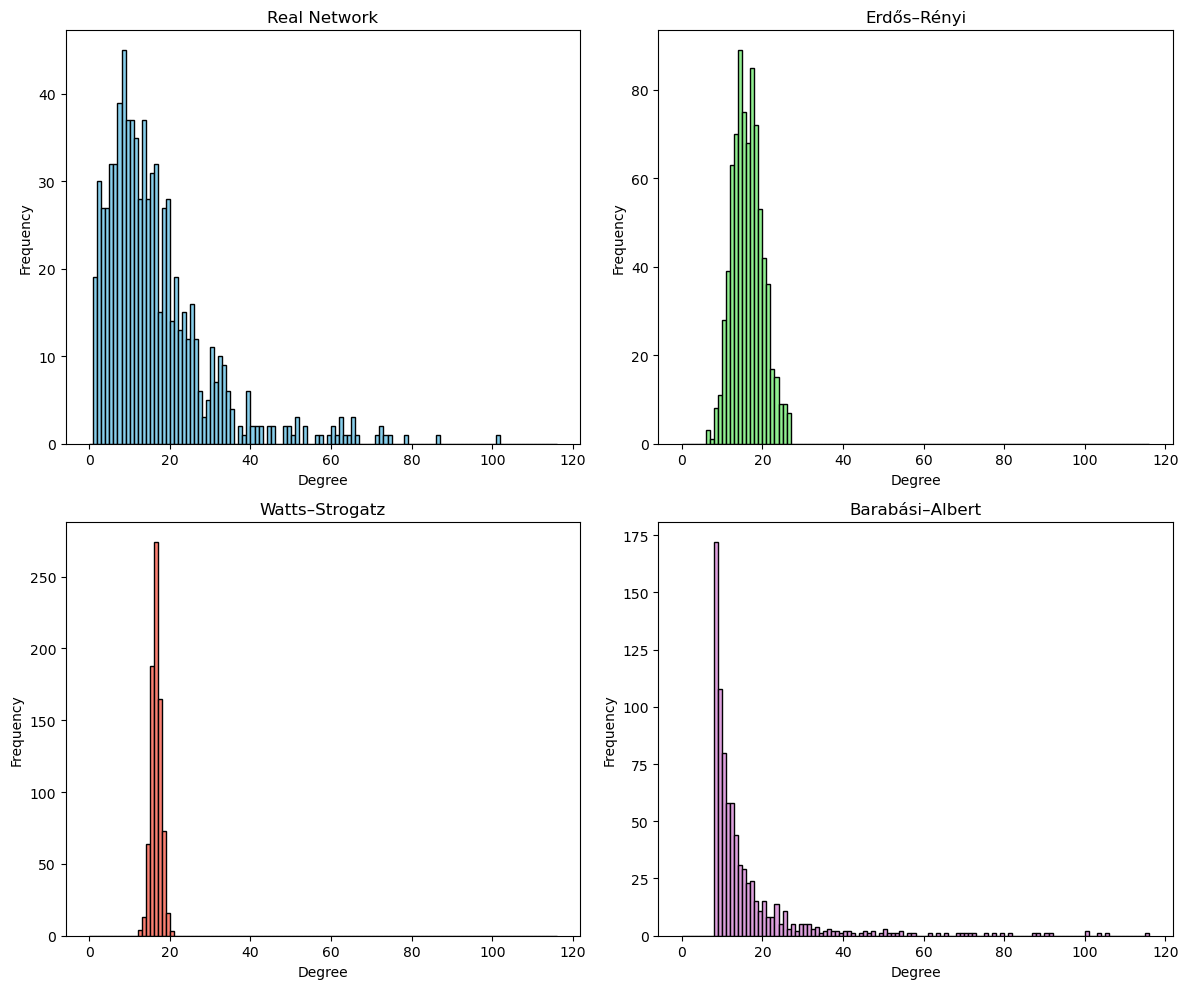

In [31]:
# Helper function to extract degrees
def get_degrees(G):
    return [d for n, d in G.degree()]

# Get degree lists
degrees_real = get_degrees(G)
degrees_er = get_degrees(G_er)
degrees_ws = get_degrees(G_ws)
degrees_ba = get_degrees(G_ba)

# Plot side-by-side histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
bins = range(0, max(max(degrees_real), max(degrees_ba)) + 1)

axs[0, 0].hist(degrees_real, bins=bins, color='skyblue', edgecolor='black')
axs[0, 0].set_title("Real Network")
axs[0, 0].set_xlabel("Degree")
axs[0, 0].set_ylabel("Frequency")

axs[0, 1].hist(degrees_er, bins=bins, color='lightgreen', edgecolor='black')
axs[0, 1].set_title("Erdős–Rényi")
axs[0, 1].set_xlabel("Degree")
axs[0, 1].set_ylabel("Frequency")

axs[1, 0].hist(degrees_ws, bins=bins, color='salmon', edgecolor='black')
axs[1, 0].set_title("Watts–Strogatz")
axs[1, 0].set_xlabel("Degree")
axs[1, 0].set_ylabel("Frequency")

axs[1, 1].hist(degrees_ba, bins=bins, color='plum', edgecolor='black')
axs[1, 1].set_title("Barabási–Albert")
axs[1, 1].set_xlabel("Degree")
axs[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


However, looking at degree distribution, the W-S model lacks the degree variation that the real FB friends model has. The B-A model has more degree variation, but lacks clustering. Since real networks have many varying patterns, they can not be fully captured by a random model. This makes me wonder, can I create some kind of hybrid model to combine the clustering of the W-S model and the degree variation of the B-A model?